# Qualitative Evaluation

In [2]:
import torch
import os
import pickle

from calweed.data import get_data
from calweed.model import get_model
from calweed.evaluate import make_predictions, print_F1_score
from calweed.metrics import expected_calibration_error, static_calibration_error, show_reliability_diagram
from calweed.calibrate import get_calibration_tecnique

In [77]:
def create_rgb_segmentation(segmentation, num_classes=None):
    """
    Convert a segmentation map to an RGB visualization using a precise colormap.

    Args:
        segmentation (torch.Tensor): Segmentation map of shape [B, H, W] where
                                      each pixel contains class labels (natural numbers).
        num_classes (int): The number of unique classes in the segmentation.

    Returns:
        torch.Tensor: RGB visualization of shape [B, 3, H, W].
    """
    if len(segmentation.shape) == 4:
        segmentation = segmentation.argmax(dim=1)
    if num_classes is None:
        num_classes = segmentation.max().item() + 1
    
    # Define a precise colormap for specific classes
    colormap = torch.tensor([
        [0, 0, 0],         # Class 0: Black (Background)
        [0, 0, 255],       # Class 4: Blue
        [255, 0, 0],       # Class 2: Red
        [0, 255, 0],       # Class 1: Green
        [255, 255, 0],     # Class 3: Yellow
        [128, 0, 128],     # Class 5: Magenta
        [0, 128, 128],     # Class 6: Cyan
        [192, 192, 192],   # Class 7: Light Gray
        [255, 0, 0],       # Class 8: Bright Red
        [0, 255, 0],       # Class 9: Bright Green
        [0, 0, 255],       # Class 10: Bright Blue
        [255, 255, 0],     # Class 11: Bright Yellow
        [255, 0, 255],     # Class 12: Bright Magenta
        [0, 255, 255],     # Class 13: Bright Cyan
        [128, 128, 128],   # Class 14: Dark Gray
        [255, 165, 0],     # Class 15: Orange
        [75, 0, 130],      # Class 16: Indigo
        [255, 20, 147],    # Class 17: Deep Pink
        [139, 69, 19],     # Class 18: Brown
        [154, 205, 50],    # Class 19: Yellow-Green
        [70, 130, 180],    # Class 20: Steel Blue
        [220, 20, 60],     # Class 21: Crimson
        [107, 142, 35],    # Class 22: Olive Drab
        [0, 100, 0],       # Class 23: Dark Green
        [205, 133, 63],    # Class 24: Peru
        [148, 0, 211],     # Class 25: Dark Violet
    ], dtype=torch.uint8)  # Ensure dtype is uint8

    # Initialize an empty tensor for RGB output
    B, H, W = segmentation.shape
    rgb_segmentation = torch.zeros((B, 3, H, W), dtype=torch.uint8)

    # Loop through each class and assign the corresponding RGB color
    for class_id in range(num_classes):
        # Create a mask for the current class
        class_mask = (segmentation == class_id).unsqueeze(1)  # Shape: [B, 1, H, W]
        # Assign the corresponding color to the rgb_segmentation
        rgb_segmentation += class_mask * colormap[class_id].view(1, 3, 1, 1)  # Broadcasting

    return rgb_segmentation

Assumes you trained and calibrated a model using the `train.py` script

In [78]:
calibration_tecnique = "temperature_scaling"
calibration_params =  "weights/segformer_calibrated_n30_temperature_scaling.pkl"
checkpoint = "weights/segformer.pth"
model = "segformer"

In [79]:

# Get data
_, _, test_dataloader = get_data()
id2label = test_dataloader.dataset.id2class

if calibration_tecnique is not None:
    cal_params = {
        "num_classes": len(id2label),
    }
    _, calibrate_fn = get_calibration_tecnique(calibration_tecnique, cal_params)
    with open(calibration_params, 'rb') as f:
        cal_params = pickle.load(f)
else:
    calibrate_fn = None
    cal_params = None
        

# Get model
torch_model = get_model(model, id2label)
weights = torch.load(checkpoint, map_location="cpu")
torch_model.load_state_dict(weights)

logits, predicted_segmentation_map, labels = make_predictions(torch_model, test_dataloader, calibrate_fn, cal_params)
logits_un, _, _ = make_predictions(torch_model, test_dataloader, None, None)

f1_metrics = print_F1_score(predicted_segmentation_map, labels, id2label)

N_BINS = 10


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


Shape of predicted_segmentation_map -> torch.Size([65, 512, 512])


100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


Shape of predicted_segmentation_map -> torch.Size([65, 512, 512])
Mean F1: 0.8046304031994603
F1 score for background (class 0): 0.9860989138630001
F1 score for crop (class 1): 0.7986642950079879
F1 score for weed (class 2): 0.6291280007273928


In [80]:
N_BINS = 10

ece, accuracy_in_bin_list, avg_confidence_in_bin_list = expected_calibration_error(
    logits, predicted_segmentation_map, labels, N_BINS
)

In [81]:
sce, sce_for_class_list = static_calibration_error(
                                                    logits,
                                                    labels,
                                                    n_bins= N_BINS
                                                )

In [82]:
sce_for_class_list

{'background': tensor grad AddBackward0 0.011,
 'crop': tensor grad AddBackward0 0.117,
 'weed': tensor grad AddBackward0 0.115}

In [83]:
import torch.nn.functional as F

probs = F.softmax(logits, dim=1)

In [84]:
probs_un = F.softmax(logits_un, dim=1)

In [85]:
import lovely_tensors as lt
lt.monkey_patch()

In [86]:
tests = next(iter(test_dataloader))

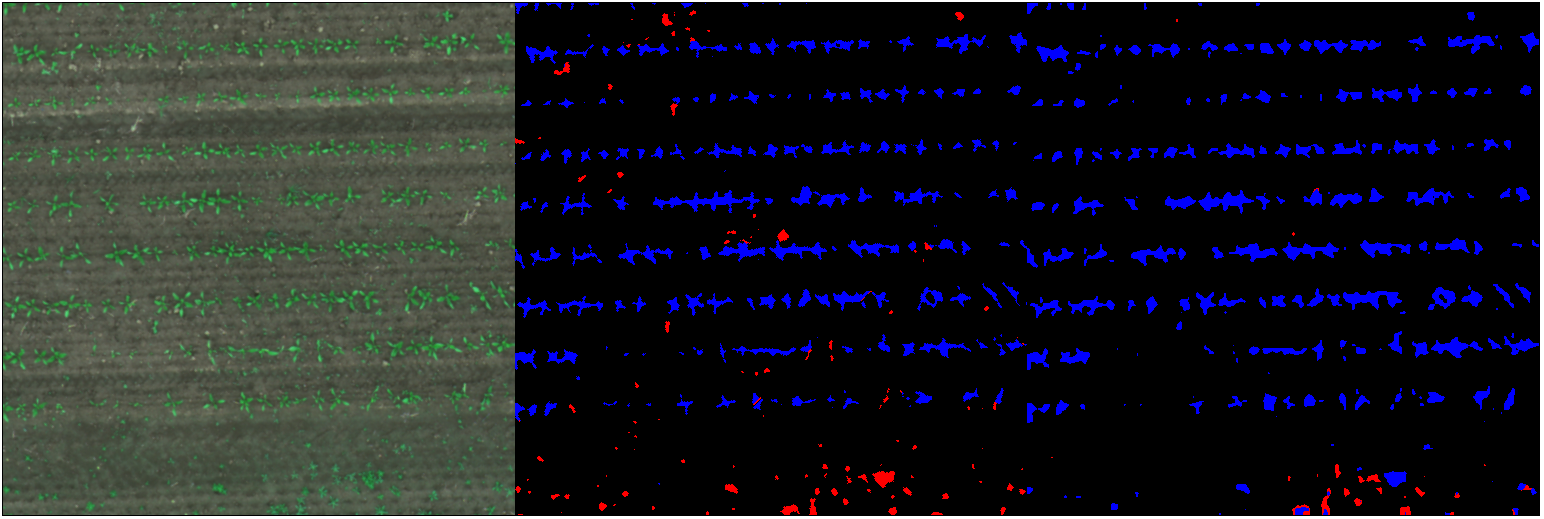

In [95]:
from einops import rearrange

s = 1

img = tests["image"][s:s+1]
rgb_gt =  create_rgb_segmentation(tests["target"][s:s+1])
rgb_pred = create_rgb_segmentation(probs[s:s+1].argmax(dim=1), num_classes=len(id2label))

tot = torch.cat([img, rgb_gt, rgb_pred], dim=-1)
tot.rgb

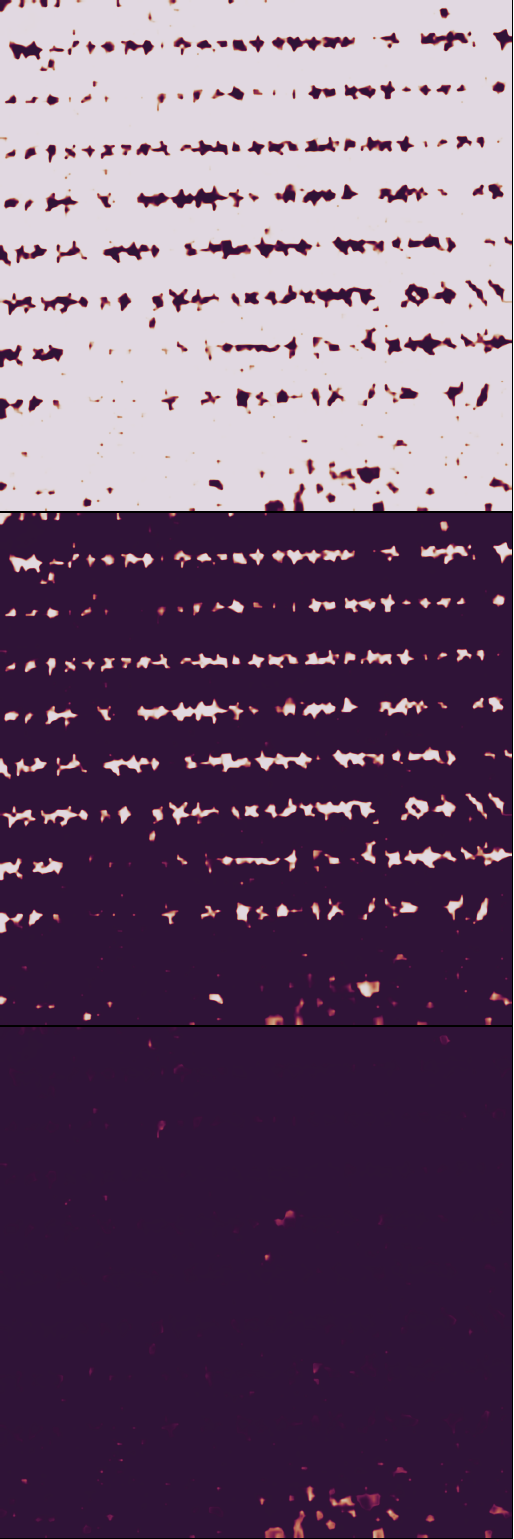

In [96]:
probs[s].chans(gutter_px=0)

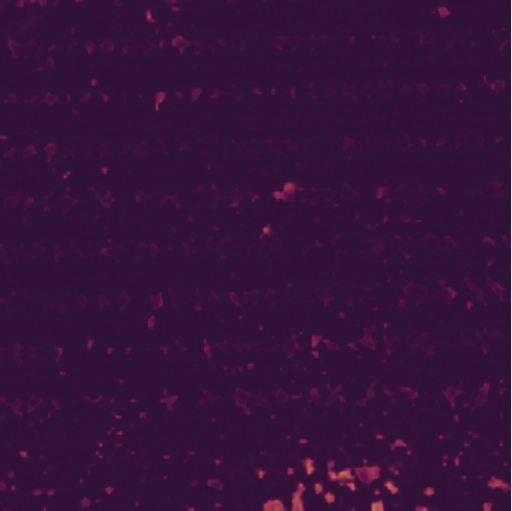

In [97]:
probs_un[s, 2].chans(gutter_px=0, frame_px=0)

In [ ]:
rgb_pred.rgb(gutter_px=0, frame_px=0).fig.savefig(f"experiments/qualit/pred_{s}.png")
rgb_gt.rgb(gutter_px=0, frame_px=0).fig.savefig(f"experiments/qualit/gt_{s}.png")
probs_un[s, 2].chans(gutter_px=0, frame_px=0).fig.savefig(f"experiments/qualit/probs_un_{s}.png")
probs[s, 2].chans(gutter_px=0, frame_px=0).fig.savefig(f"experiments/qualit/probs_{s}.png")
img[0].rgb(gutter_px=0, frame_px=0).fig.savefig(f"experiments/qualit/img_{s}.png")